In [14]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np
from time import time
import matplotlib.pyplot as plt
from matplotlib import cm
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
dde.config.set_default_float("float64")

Num GPUs Available:  1
Set the default float type to float64


In [15]:
t0 = time()
geom= dde.geometry.Interval(0,2*np.pi)
timedomain = dde.geometry.TimeDomain(0,0.8)
geotime = dde.geometry.GeometryXTime(geom,timedomain)

def pde(x,y):
    dy_x = dde.grad.jacobian(y,x,i=0,j=0)
    dy_t = dde.grad.jacobian(y,x,i=0,j=1)
    dy_xx = dde.grad.hessian(y,x,i=0,j=0)
    return dy_t + y*dy_x - 0.001*dy_xx - tf.sin(x[:,0:1])

bc = dde.icbc.DirichletBC(geotime,lambda x: 0, lambda _,on_boundary:on_boundary)
ic = dde.icbc.IC(geotime,lambda x:np.sin(x[:,0:1]),lambda _,on_initial:on_initial)

data = dde.data.TimePDE(geotime,pde,[bc,ic],num_domain=20000,num_boundary=2000,num_initial=8000)

net = dde.nn.FNN([2]+[50]*4+[1],'tanh','Glorot normal')

model5 = dde.Model(data,net)
model5.compile("adam", lr=1e-3)
print("learning rate = ",1e-3)
model5.train(iterations=15000)
model5.compile("L-BFGS")
losshistory, train_state = model5.train()
t1 = time()
print("Total time taken:",t1-t0,"sec")

Compiling model...
Building feed-forward neural network...
'build' took 0.056591 s



2023-04-23 15:51:20.991169: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78977 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


'compile' took 0.592931 s

learning rate =  0.001
Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.73e-01, 1.22e-01, 6.35e-01]    [4.73e-01, 1.22e-01, 6.35e-01]    []  
1000      [3.51e-03, 1.68e-05, 2.48e-03]    [3.51e-03, 1.68e-05, 2.48e-03]    []  
2000      [1.24e-03, 8.10e-06, 1.11e-03]    [1.24e-03, 8.10e-06, 1.11e-03]    []  
3000      [6.75e-04, 3.06e-06, 6.41e-04]    [6.75e-04, 3.06e-06, 6.41e-04]    []  
4000      [4.37e-04, 1.43e-06, 4.20e-04]    [4.37e-04, 1.43e-06, 4.20e-04]    []  
5000      [3.22e-04, 9.29e-07, 2.83e-04]    [3.22e-04, 9.29e-07, 2.83e-04]    []  
6000      [2.61e-04, 5.30e-06, 2.23e-04]    [2.61e-04, 5.30e-06, 2.23e-04]    []  
7000      [1.88e-04, 7.38e-06, 1.73e-04]    [1.88e-04, 7.38e-06, 1.73e-04]    []  
8000      [1.39e-04, 3.24e-06, 1.25e-04]    [1.39e-04, 3.24e-06, 1.25e-04]    []  
9000      [1.08e-04, 4.00e-07, 9.81e-05]    [1.08e-04, 4.00e-07, 9.8

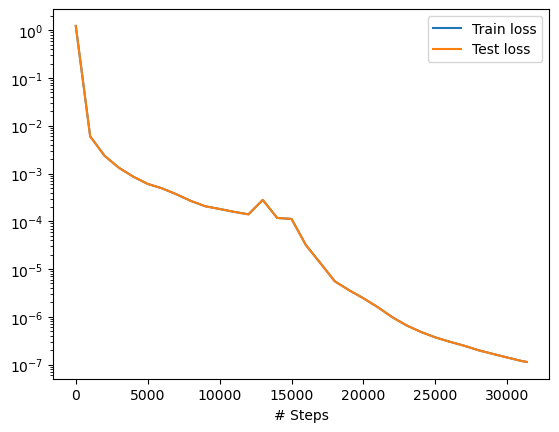

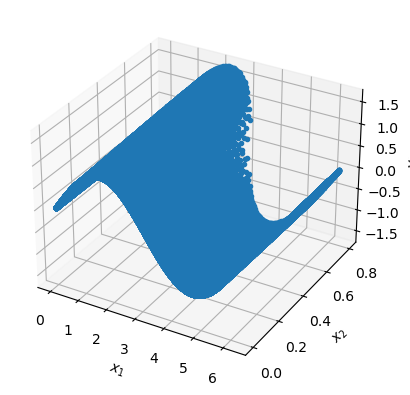

In [16]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

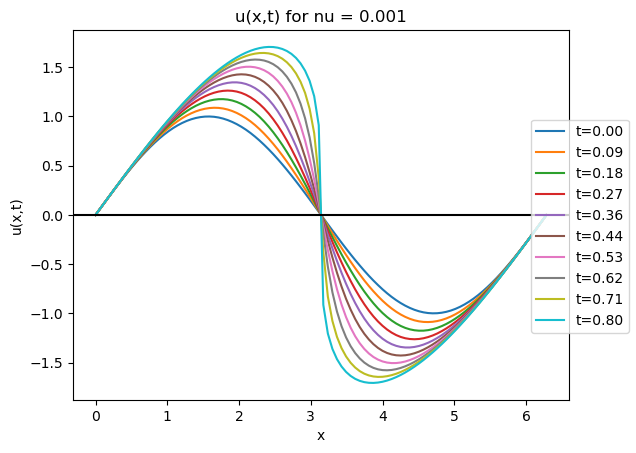

In [17]:
number_of_plots = 10
t1 = np.linspace(0,0.8,number_of_plots)

fig=plt.figure(1)#,figsize=(10,8)
x = np.linspace(0,2*np.pi,100)
#fig,axes = plt.subplots(number_of_plots,figsize=(6,number_of_plots*6))
for i in range(number_of_plots):
    
    t = t1[i] * np.ones_like(x)
    X_T = np.concatenate([x.reshape(100,1),t.reshape(100,1)],axis=1)
    z = model5.predict(X_T)
    plt.plot(x,z,label="t=%.2f"%(t1[i]))
    
plt.axhline(y=0,xmin=0.0,xmax=2*np.pi,c="black")
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title("u(x,t) for nu = 0.001")
fig.legend(loc='outside right')

In [18]:
timedomain2 = dde.geometry.TimeDomain(0.8,1.5)
geotime2 = dde.geometry.GeometryXTime(geom,timedomain2)
bc = dde.icbc.DirichletBC(geotime2,lambda x: 0, lambda _,on_boundary:on_boundary)
ic2 = dde.icbc.IC(geotime2,lambda x:model5.predict(x),lambda _,on_initial:on_initial)

data2 = dde.data.TimePDE(geotime2,pde,[bc,ic2],num_domain=30000,num_boundary=4000,num_initial=9000)

net2 = dde.nn.FNN([2]+[50]*4+[1],'tanh','Glorot normal')

model6 = dde.Model(data2,net2)
model6.compile("adam", lr=1e-3)
print("learning rate = ",1e-3)
model6.train(iterations=15000)
model6.compile("L-BFGS")
losshistory, train_state = model6.train()

Compiling model...
Building feed-forward neural network...
'build' took 0.052894 s



2023-04-23 16:00:02.444516: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78977 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:ca:00.0, compute capability: 8.0


'compile' took 0.996960 s

learning rate =  0.001
Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.57e-01, 2.22e-01, 1.71e+00]    [5.57e-01, 2.22e-01, 1.71e+00]    []  
1000      [7.45e-02, 2.51e-05, 2.14e-01]    [7.45e-02, 2.51e-05, 2.14e-01]    []  
2000      [6.28e-02, 6.99e-05, 1.96e-01]    [6.28e-02, 6.99e-05, 1.96e-01]    []  
3000      [6.00e-02, 4.13e-06, 1.83e-01]    [6.00e-02, 4.13e-06, 1.83e-01]    []  
4000      [5.82e-02, 7.21e-06, 1.60e-01]    [5.82e-02, 7.21e-06, 1.60e-01]    []  
5000      [1.43e-01, 9.37e-05, 3.58e-01]    [1.43e-01, 9.37e-05, 3.58e-01]    []  
6000      [7.23e-02, 5.80e-05, 2.15e-01]    [7.23e-02, 5.80e-05, 2.15e-01]    []  
7000      [6.47e-02, 7.86e-06, 1.96e-01]    [6.47e-02, 7.86e-06, 1.96e-01]    []  
8000      [6.20e-02, 1.23e-04, 1.88e-01]    [6.20e-02, 1.23e-04, 1.88e-01]    []  
9000      [6.24e-02, 2.22e-06, 1.80e-01]    [6.24e-02, 2.22e-06, 1.8

2023-04-23 16:01:50.675576: W tensorflow/c/c_api.cc:291] Operation '{name:'dense_19/bias/Assign' id:5679 op device:{requested: '', assigned: ''} def:{{{node dense_19/bias/Assign}} = Assign[T=DT_DOUBLE, _class=["loc:@dense_19/bias"], _has_manual_control_dependencies=true, use_locking=true, validate_shape=true](dense_19/bias, dense_19/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


'compile' took 0.857405 s

Training model...

Step      Train loss                        Test loss                         Test metric
15000     [6.69e-02, 3.55e-06, 1.78e-01]    [6.69e-02, 3.55e-06, 1.78e-01]    []  
16000     [6.64e-02, 2.10e-05, 1.20e-01]    [6.64e-02, 2.10e-05, 1.20e-01]        
17000     [4.79e-03, 6.23e-06, 2.47e-02]    [4.79e-03, 6.23e-06, 2.47e-02]        
18000     [4.34e-03, 1.87e-06, 2.04e-02]    [4.34e-03, 1.87e-06, 2.04e-02]        
19000     [4.10e-03, 1.09e-05, 1.59e-02]    [4.10e-03, 1.09e-05, 1.59e-02]        
20000     [4.08e-03, 5.87e-06, 1.11e-02]    [4.08e-03, 5.87e-06, 1.11e-02]        
21000     [3.52e-03, 4.24e-06, 9.19e-03]    [3.52e-03, 4.24e-06, 9.19e-03]        
22000     [2.81e-03, 1.41e-06, 7.96e-03]    [2.81e-03, 1.41e-06, 7.96e-03]        
23000     [2.48e-03, 3.12e-06, 6.47e-03]    [2.48e-03, 3.12e-06, 6.47e-03]        
24000     [2.15e-03, 6.13e-06, 5.55e-03]    [2.15e-03, 6.13e-06, 5.55e-03]        
25000     [1.57e-03, 7.01e-06, 4.9

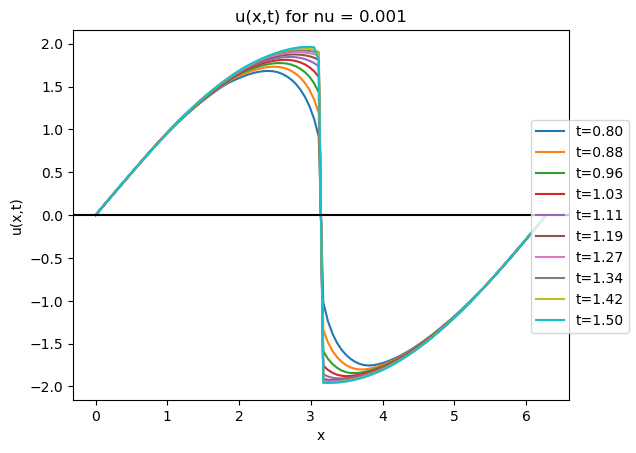

In [19]:
number_of_plots = 10
t1 = np.linspace(0.8,1.5,number_of_plots)

fig=plt.figure(1)#,figsize=(10,8)
x = np.linspace(0,2*np.pi,100)
#fig,axes = plt.subplots(number_of_plots,figsize=(6,number_of_plots*6))
for i in range(number_of_plots):
    
    t = t1[i] * np.ones_like(x)
    X_T = np.concatenate([x.reshape(100,1),t.reshape(100,1)],axis=1)
    z = model6.predict(X_T)
    plt.plot(x,z,label="t=%.2f"%(t1[i]))
    
plt.axhline(y=0,xmin=0.0,xmax=2*np.pi,c="black")
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title("u(x,t) for nu = 0.001")
fig.legend(loc='outside right')

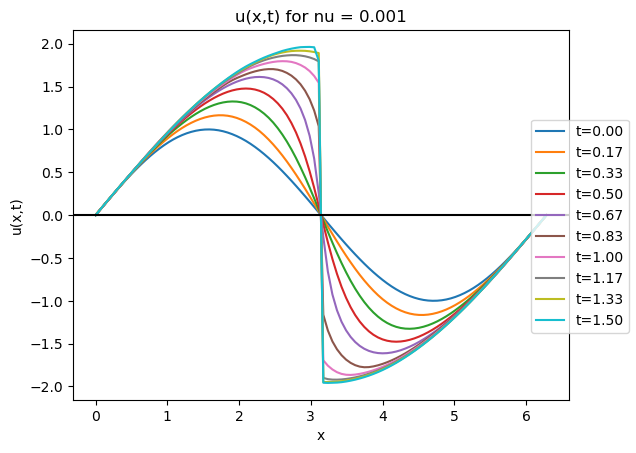

In [20]:
number_of_plots = 10
t1 = np.linspace(0,1.5,number_of_plots)
fig1=plt.figure(1)#,figsize=(12,10))
x = np.linspace(0,2*np.pi,100)
#fig,axes = plt.subplots(number_of_plots,figsize=(6,number_of_plots*6))
for i in range(number_of_plots):
    if t1[i]<0.8:
        t = t1[i] * np.ones_like(x)
        X_T = np.concatenate([x.reshape(100,1),t.reshape(100,1)],axis=1)
        z = model5.predict(X_T)
        plt.plot(x,z,label="t=%.2f"%(t1[i]))

    else:
        t = t1[i] * np.ones_like(x)
        X_T = np.concatenate([x.reshape(100,1),t.reshape(100,1)],axis=1)
        z = model6.predict(X_T)
        plt.plot(x,z,label="t=%.2f"%(t1[i]))
plt.axhline(y=0,xmin=0.0,xmax=2*np.pi,c="black")    
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.title("u(x,t) for nu = 0.001")
fig1.legend(loc="outside right")
#plt.savefig('RADdec1100110.png')
plt.show()

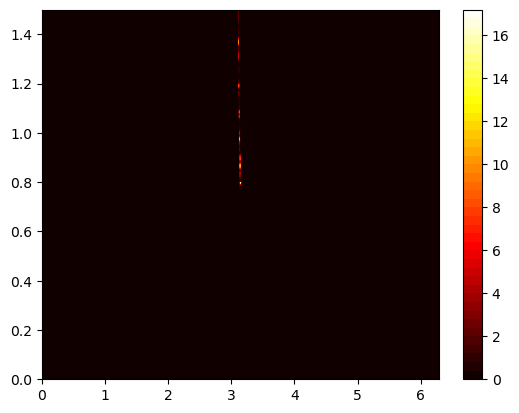

In [21]:
def pred_res(x):
    a = 0
    for i in range(len(x)):
        if x[i][1]>0.8:
            a = i
            break
    y1 = model5.predict(x[:a],operator=pde)
    y2 = model6.predict(x[a:],operator=pde)
    y = np.concatenate((y1, y2), axis=0)
    return y

#Figure 2
plt.figure(2)#,figsize=(12,10))
t1=np.linspace(0,1.5,1000)
x=np.linspace(0,2*np.pi,1000)
xx, tt = np.meshgrid(x, t1)

X=np.concatenate([xx.reshape(1000,1000,1),tt.reshape(1000,1000,1)],axis=2)
f1 = np.abs(pred_res(X.reshape((1000000,2))))

s=plt.contourf(xx,tt,f1.reshape(1000,1000),50)
cmap = plt.get_cmap('hot')
plt.set_cmap(cmap)
plt.colorbar()

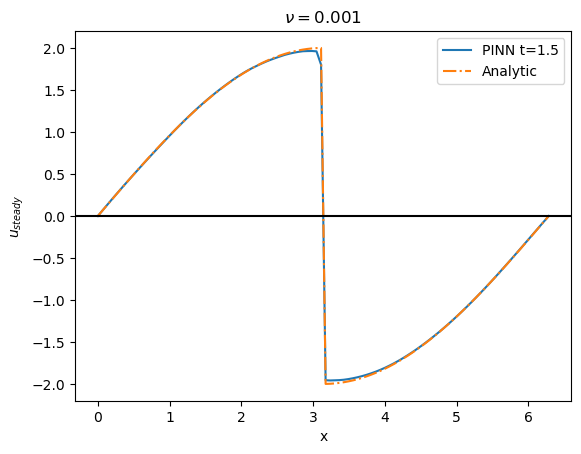

In [22]:
def sgn(x):
    out = []
    for i in x:
        if i<0:
            out.append(1.0)
        else:
            out.append(-1.0)
    return np.array(out)


def u(x,nu):
    return 2*sgn(x-np.pi)*(np.sin(x/2)-1) +2*np.tanh((np.pi-x)/nu)

x = np.linspace(0,2*np.pi,100)
t = 1.5 * np.ones_like(x)
X_T = np.concatenate([x.reshape(100,1),t.reshape(100,1)],axis=1)
z = model6.predict(X_T)
plt.plot(x,z,label="PINN t=1.5")
u_0_01 = u(x,0.001)
plt.plot(x,u_0_01,'-.',label='Analytic')
plt.axhline(y=0,xmin=0.0,xmax=2*np.pi,c="black")

plt.xlabel('x')
plt.ylabel('$u_{steady}$')
plt.title(r'$\nu =0.001$')
plt.legend()

Text(0.5, 1.0, '$\\nu$=0.001')

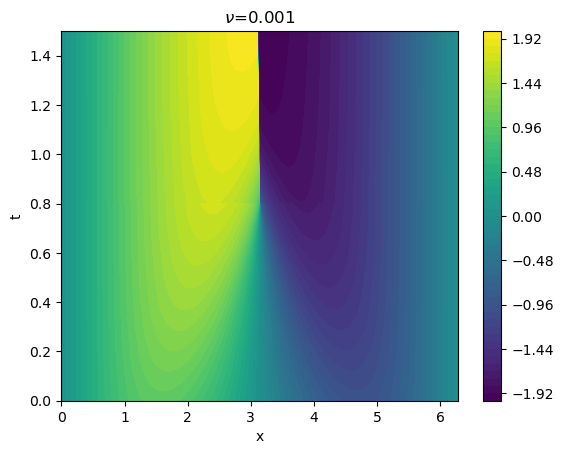

In [24]:
def pred_sol(x):
    a = 0
    for i in range(len(x)):
        if x[i][1]>0.8:
            a = i
            break
    y1 = model5.predict(x[:a])
    y2 = model6.predict(x[a:])
    y = np.concatenate((y1, y2), axis=0)
    return y
t=np.linspace(0.0,1.5,1000)
x=np.linspace(0.0,2*np.pi,1000)
xx, tt = np.meshgrid(x, t)
X=np.concatenate([xx.reshape(1000,1000,1),tt.reshape(1000,1000,1)],axis=2)
f1 = pred_sol(X.reshape((1000000,2)))
s=plt.contourf(xx,tt,f1.reshape(1000,1000),50)
cmap = plt.get_cmap('viridis')
plt.set_cmap(cmap)
plt.colorbar(s)
plt.xlabel("x")
plt.ylabel("t")
plt.title(r"$\nu$=0.001")

In [12]:
# dde.optimizers.config.set_LBFGS_options(maxiter=4000)
# k = 1.3
# c = 1
# for i in range(10):
#     print("Resampling State:",i+1)
#     X = geotime2.random_points(250000)
#     Y = np.abs(model6.predict(X, operator=pde)).astype(np.float64)
#     err_eq = np.power(Y, k) / np.power(Y, k).mean() + c
#     err_eq_normalized = (err_eq / sum(err_eq))[:, 0]
#     X_ids = np.random.choice(a=len(X), size=30000, replace=False, p=err_eq_normalized)
#     X_selected = X[X_ids]
#     data2.replace_with_anchors(X_selected)

#     model6.compile("adam", lr=0.001)
#     model6.train(epochs=2000)
#     model6.compile("L-BFGS")
#     losshistory, train_state = model6.train()

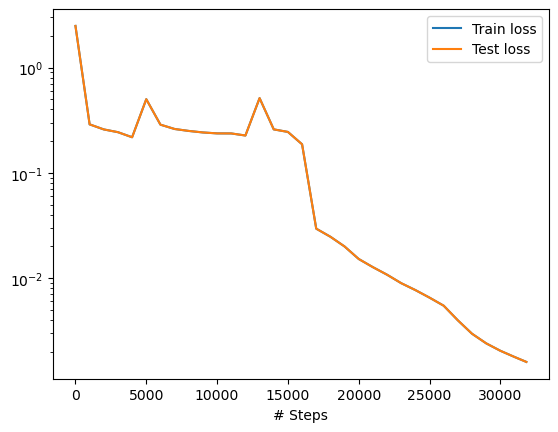

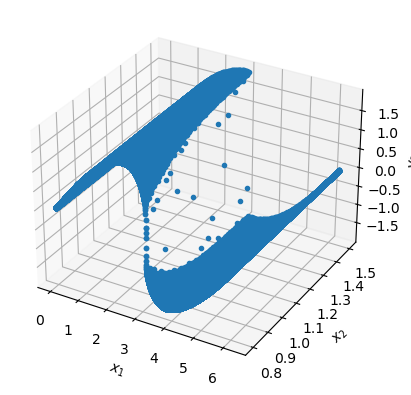

In [25]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)